In [3]:
# Tested on python 3.6.4 
%matplotlib inline

import numpy as np # 1.13.3
from scipy.integrate import odeint # 1.0.0
import scipy.optimize as op
import scipy.stats as stats
import matplotlib.pyplot as plt # 2.1.1
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator

import pandas as pd # 0.22.0
import emcee # 2.2.1
import corner # 2.0.1
import progressbar # 3.34.3
import seaborn as sns # 0.8.1
from cycler import cycler # 0.10.0

from helper import * # helper.py

print('emcee version', emcee.__version__)

# Directories defined here 
DIR_DATA = './data/'
DIR_PLOTS = './plots/'
DIR_OUT = './output/'

emcee version 2.2.1


This jupyter notebook determines the dose response sensitivity of cooperative-repression data from the 2018 Swank et al. paper. The code in this notebook requires the following data files, which are located in `DIR_DATA`

    2site_coop_PDZ.csv
    2site_coop_GCN.csv
    
as well as the following output files, located in `DIR_OUT`:

    samplesout_PDZ_dualbind.csv
    samplesout_GCN_dualbind.csv
    
The results are used to generate Supplementary Figure S5. Plots are written into `DIR_PLOTS`.

In [4]:
# Define models

def model_single(A,C0,K,x,Erp):
    Freg = (1+x/K*np.exp(-Erp))/(1+x/K)
    return A/(1+C0/Freg) # Returns protein level (occupancy*A)

def model_dual(A,C0,K1,K2,x1,x2,Erp1,Erp2,Er1r2):
    Freg12 = (1+x1/K1*np.exp(-Erp1)+x2/K2*np.exp(-Erp2)+x1*x2/K1/K2*np.exp(-Erp1-Erp2-Er1r2))/(1+x1/K1+x2/K2+x1*x2/K1/K2*np.exp(-Er1r2))
    return A/(1+C0/Freg12) # Returns protein level (occupancy*A)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log


slope,error 1 =  -0.597552865066 0.00678745336373
slope,error 2 =  -0.311954336348 0.00262183873784
slope,error 3 =  -0.165819576584 0.00117880660799
slope,error 4 =  -0.181603705318 0.00152192651883


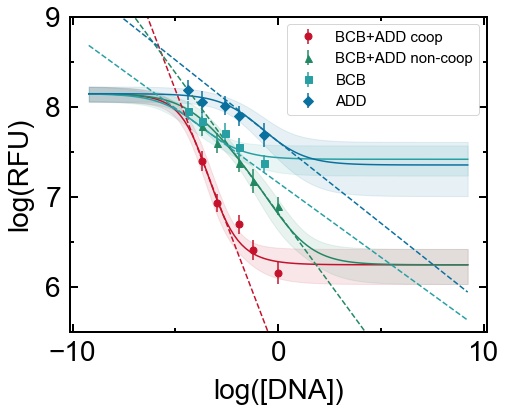

In [5]:
### Read PDZ data
np.random.seed(0) # For reproducible outputs
df = pd.read_csv(DIR_DATA+'2site_coop_PDZ.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-PDZ', 'ADD-L']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-PDZ std', 'ADD-L std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values


### Read MCMC data
nwalkers,ndim,iterations,tburn = 50,7,10000,5000
ZFname = 'PDZ_dualbind'

df1 = pd.read_csv(DIR_OUT+'samplesout_'+ZFname+'.csv',delimiter=',')
data = np.zeros(df1.shape[0]*(df1.shape[1]-1)).reshape(df1.shape[0],(df1.shape[1]-1))
for i in range(0,int(df1.shape[1]-1)):
    data[:,i] = np.array(df1.iloc[:,i+1]) # Put dataframe into array. Dataframe has no. columns = no. parameters.

### Burn-in time correction
data2 = np.zeros((df1.shape[0]-tburn*nwalkers)*(df1.shape[1]-1)).reshape((df1.shape[0]-(tburn*nwalkers)),(df1.shape[1]-1))
for i in range(0,int(df1.shape[1]-1)):
    for j in range(1,nwalkers+1):
        data2[(iterations-tburn)*(j-1):(iterations-tburn)*(j),i]=np.array(df1.iloc[iterations*j-iterations+tburn:iterations*j,i+1])
samples_noburn = data2
        
### Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs
modelscale = np.logspace(-4,4,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))
ypred2 = np.zeros((len(modelscale),numberofmodeltraces))
ypred3 = np.zeros((len(modelscale),numberofmodeltraces))
ypred4 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for A,C0,K1,K2,Erp1,Erp2,Er1r2 in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred4[:,i] = model_single(A,C0,K1,modelscale,Erp1)
    ypred3[:,i] = model_single(A,C0,K2,modelscale,Erp2)
    ypred2[:,i] = model_dual(A,C0,K1,K2,modelscale/2,modelscale/2,Erp1,Erp2,0)
    ypred1[:,i] = model_dual(A,C0,K1,K2,modelscale/2,modelscale/2,Erp1,Erp2,Er1r2)            
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]
quant2 = [np.mean(ypred2,axis=1)-2*np.std(ypred2,axis=1),
          np.mean(ypred2,axis=1),
          np.mean(ypred2,axis=1)+2*np.std(ypred2,axis=1)]
quant3 = [np.mean(ypred3,axis=1)-2*np.std(ypred3,axis=1),
          np.mean(ypred3,axis=1),
          np.mean(ypred3,axis=1)+2*np.std(ypred3,axis=1)]
quant4 = [np.mean(ypred4,axis=1)-2*np.std(ypred4,axis=1),
          np.mean(ypred4,axis=1),
          np.mean(ypred4,axis=1)+2*np.std(ypred4,axis=1)]

plt.close("all")

my_dpi=150

figure_options={'figsize':(8.27,5.83)} #figure size in inches. A4=11.7x8.3. A5=8.27,5.83
font_options={'size':'28','family':'sans-serif','sans-serif':'Arial'}
plt.rc('figure', **figure_options)
plt.rc('font', **font_options)

current_palette=sns.color_palette("deep", 4)
plt.rc('axes',prop_cycle=(cycler('color',current_palette)))
f, axarr=plt.subplots()
plt.subplots_adjust(left=0.25,bottom=0.2,right=0.95,top=0.95)

# Plot data

axarr.errorbar(np.log(titration),np.log(y1),yerr=1/y1*yerr1,fmt='o',ms=7,label='BCB+ADD coop',color='#C4122C')
axarr.errorbar(np.log(titration),np.log(y2),yerr=1/y2*yerr2,fmt='^',ms=7,label='BCB+ADD non-coop',color='#228863')
axarr.errorbar(np.log(titration/2),np.log(y3),yerr=1/y3*yerr3,fmt='s',ms=7,label='BCB',color='#28A0A3')
axarr.errorbar(np.log(titration/2),np.log(y4),yerr=1/y4*yerr4,fmt='D',ms=7,label='ADD',color='#0A719F')

# Plot model

axarr.fill_between(np.log(modelscale),np.log(quant1[0]),np.log(quant1[2]),color='#C4122C',alpha=0.1)
axarr.fill_between(np.log(modelscale),np.log(quant2[0]),np.log(quant2[2]),color='#228863',alpha=0.1)
axarr.fill_between(np.log(modelscale),np.log(quant3[0]),np.log(quant3[2]),color='#28A0A3',alpha=0.1)
axarr.fill_between(np.log(modelscale),np.log(quant4[0]),np.log(quant4[2]),color='#0A719F',alpha=0.1)

axarr.plot(np.log(modelscale),np.log(quant1[1]),'-',color='#C4122C',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),np.log(quant2[1]),'-',color='#228863',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),np.log(quant3[1]),'-',color='#28A0A3',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),np.log(quant4[1]),'-',color='#0A719F',alpha=1,lw=1.5)

# Fit sensitivities 

def fit(x,y):
    mid = 0.5*(np.log(np.max(y))+np.log(np.min(y)))
    idx = np.abs(np.log(y)-mid).argmin()
    xfit = np.log(x[idx-5:idx+5])
    yfit = np.log(y[idx-5:idx+5])
    slope, intercept, r_value, p_value, std_err = stats.linregress(xfit,yfit)
    return(slope,intercept,std_err,xfit,yfit)
        
m1,c1,err1,xfit1,yfit1 = fit(modelscale,quant1[1])
m2,c2,err2,xfit2,yfit2 = fit(modelscale,quant2[1])
m3,c3,err3,xfit3,yfit3 = fit(modelscale,quant3[1])
m4,c4,err4,xfit4,yfit4 = fit(modelscale,quant4[1])

axarr.plot(np.log(modelscale),m1*np.log(modelscale)+c1,'--',color='#C4122C',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),m2*np.log(modelscale)+c2,'--',color='#228863',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),m3*np.log(modelscale)+c3,'--',color='#28A0A3',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),m4*np.log(modelscale)+c4,'--',color='#0A719F',alpha=1,lw=1.5)

formatplot(axarr,'log([DNA])','log(RFU)', xlim=False,ylim=([5.5,9]),symlogx=False)

axarr.legend(loc='best', fontsize=15,numpoints=1)
plt.savefig(DIR_PLOTS+ZFname+'_sens.pdf',dpi=my_dpi,transparent=True)

print('slope,error 1 = ',m1,err1)
print('slope,error 2 = ',m2,err2)
print('slope,error 3 = ',m3,err3)
print('slope,error 4 = ',m4,err4)

# Ignore divide by zero errors due to log of [DNA]=0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log


slope,error 1 =  -0.631393661609 0.00867899077252
slope,error 2 =  -0.423319385895 0.00240034714072
slope,error 3 =  -0.16853142215 0.00117600441917
slope,error 4 =  -0.181587434811 0.00109848014998


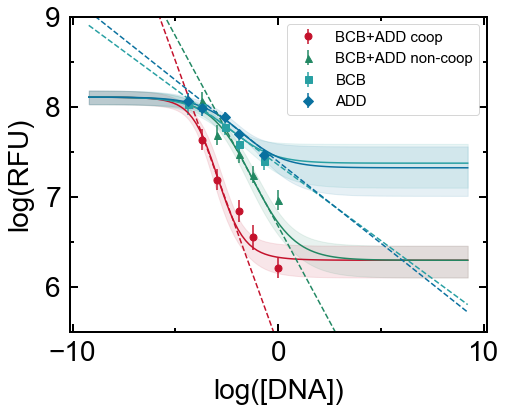

In [6]:
### Read GCN data
np.random.seed(0) # For reproducible outputs
df = pd.read_csv(DIR_DATA+'2site_coop_GCN.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-GCN', 'ADD-GCN']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-GCN std', 'ADD-GCN std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

### Read MCMC data
nwalkers,ndim,iterations,tburn = 50,7,10000,5000
ZFname = 'GCN_dualbind'

df1 = pd.read_csv(DIR_OUT+'samplesout_'+ZFname+'.csv',delimiter=',')
data = np.zeros(df1.shape[0]*(df1.shape[1]-1)).reshape(df1.shape[0],(df1.shape[1]-1))
for i in range(0,int(df1.shape[1]-1)):
    data[:,i] = np.array(df1.iloc[:,i+1]) # Put dataframe into array. Dataframe has no. columns = no. parameters.
    
### Burn-in time correction

data2 = np.zeros((df1.shape[0]-tburn*nwalkers)*(df1.shape[1]-1)).reshape((df1.shape[0]-(tburn*nwalkers)),(df1.shape[1]-1))
for i in range(0,int(df1.shape[1]-1)):
    for j in range(1,nwalkers+1):
        data2[(iterations-tburn)*(j-1):(iterations-tburn)*(j),i]=np.array(df1.iloc[iterations*j-iterations+tburn:iterations*j,i+1])
samples_noburn = data2
        
### Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs
modelscale = np.logspace(-4,4,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))
ypred2 = np.zeros((len(modelscale),numberofmodeltraces))
ypred3 = np.zeros((len(modelscale),numberofmodeltraces))
ypred4 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for A,C0,K1,K2,Erp1,Erp2,Er1r2 in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred4[:,i] = model_single(A,C0,K1,modelscale,Erp1)
    ypred3[:,i] = model_single(A,C0,K2,modelscale,Erp2)
    ypred2[:,i] = model_dual(A,C0,K1,K2,modelscale/2,modelscale/2,Erp1,Erp2,0)
    ypred1[:,i] = model_dual(A,C0,K1,K2,modelscale/2,modelscale/2,Erp1,Erp2,Er1r2)            
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]
quant2 = [np.mean(ypred2,axis=1)-2*np.std(ypred2,axis=1),
          np.mean(ypred2,axis=1),
          np.mean(ypred2,axis=1)+2*np.std(ypred2,axis=1)]
quant3 = [np.mean(ypred3,axis=1)-2*np.std(ypred3,axis=1),
          np.mean(ypred3,axis=1),
          np.mean(ypred3,axis=1)+2*np.std(ypred3,axis=1)]
quant4 = [np.mean(ypred4,axis=1)-2*np.std(ypred4,axis=1),
          np.mean(ypred4,axis=1),
          np.mean(ypred4,axis=1)+2*np.std(ypred4,axis=1)]

plt.close("all")

my_dpi=150

figure_options={'figsize':(8.27,5.83)} #figure size in inches. A4=11.7x8.3. A5=8.27,5.83
font_options={'size':'28','family':'sans-serif','sans-serif':'Arial'}
plt.rc('figure', **figure_options)
plt.rc('font', **font_options)

current_palette=sns.color_palette("deep", 4)
plt.rc('axes',prop_cycle=(cycler('color',current_palette)))
f, axarr=plt.subplots()
plt.subplots_adjust(left=0.25,bottom=0.2,right=0.95,top=0.95)

# Plot data

axarr.errorbar(np.log(titration),np.log(y1),yerr=1/y1*yerr1,fmt='o',ms=7,label='BCB+ADD coop',color='#C4122C')
axarr.errorbar(np.log(titration),np.log(y2),yerr=1/y2*yerr2,fmt='^',ms=7,label='BCB+ADD non-coop',color='#228863')
axarr.errorbar(np.log(titration/2),np.log(y3),yerr=1/y3*yerr3,fmt='s',ms=7,label='BCB',color='#28A0A3')
axarr.errorbar(np.log(titration/2),np.log(y4),yerr=1/y4*yerr4,fmt='D',ms=7,label='ADD',color='#0A719F')

# Plot model

axarr.fill_between(np.log(modelscale),np.log(quant1[0]),np.log(quant1[2]),color='#C4122C',alpha=0.1)
axarr.fill_between(np.log(modelscale),np.log(quant2[0]),np.log(quant2[2]),color='#228863',alpha=0.1)
axarr.fill_between(np.log(modelscale),np.log(quant3[0]),np.log(quant3[2]),color='#28A0A3',alpha=0.1)
axarr.fill_between(np.log(modelscale),np.log(quant4[0]),np.log(quant4[2]),color='#0A719F',alpha=0.1)

axarr.plot(np.log(modelscale),np.log(quant1[1]),'-',color='#C4122C',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),np.log(quant2[1]),'-',color='#228863',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),np.log(quant3[1]),'-',color='#28A0A3',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),np.log(quant4[1]),'-',color='#0A719F',alpha=1,lw=1.5)

# Fit sensitivities 

def fit(x,y):
    mid = 0.5*(np.log(np.max(y))+np.log(np.min(y)))
    idx = np.abs(np.log(y)-mid).argmin()
    xfit = np.log(x[idx-5:idx+5])
    yfit = np.log(y[idx-5:idx+5])
    slope, intercept, r_value, p_value, std_err = stats.linregress(xfit,yfit)
    return(slope,intercept,std_err,xfit,yfit)
        
m1,c1,err1,xfit1,yfit1 = fit(modelscale,quant1[1])
m2,c2,err2,xfit2,yfit2 = fit(modelscale,quant2[1])
m3,c3,err3,xfit3,yfit3 = fit(modelscale,quant3[1])
m4,c4,err4,xfit4,yfit4 = fit(modelscale,quant4[1])

axarr.plot(np.log(modelscale),m1*np.log(modelscale)+c1,'--',color='#C4122C',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),m2*np.log(modelscale)+c2,'--',color='#228863',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),m3*np.log(modelscale)+c3,'--',color='#28A0A3',alpha=1,lw=1.5)
axarr.plot(np.log(modelscale),m4*np.log(modelscale)+c4,'--',color='#0A719F',alpha=1,lw=1.5)

formatplot(axarr,'log([DNA])','log(RFU)', xlim=False,ylim=([5.5,9]),symlogx=False)

axarr.legend(loc='best', fontsize=15,numpoints=1)
plt.savefig(DIR_PLOTS+ZFname+'_sens.pdf',dpi=my_dpi,transparent=True)

print('slope,error 1 = ',m1,err1)
print('slope,error 2 = ',m2,err2)
print('slope,error 3 = ',m3,err3)
print('slope,error 4 = ',m4,err4)

# Ignore divide by zero errors due to log of [DNA]=0